# 라이브러리 import

In [1]:
# 캐글
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [2]:
import os
from glob import glob

import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras import layers

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
# os.listdir('train')

In [5]:
from zipfile import ZipFile
with ZipFile('/content/drive/My Drive/data/aerial-cactus-identification.zip')as zip_obj :
  zip_obj.extractall()
with ZipFile('/content/test.zip')as test_obj :
  test_obj.extractall()
with ZipFile('/content/train.zip')as train_obj :
  train_obj.extractall()

## 데이터 확인

## csv파일 확인
 - ```train.csv``` : id, has_cactus가 담겨 있으며 총 17500개의 데이터
  - train데이터에 관한 csv
 - ```sample_submission.csv``` : 구성은 같으며 4000개의 데이터
  - test데이터에 관한 csv

In [6]:
df = pd.read_csv('/content/train.csv')
print(df.head())

file_list = df['id']
has_cactus = df['has_cactus']
print(len(file_list), len(has_cactus))

                                     id  has_cactus
0  0004be2cfeaba1c0361d39e2b000257b.jpg           1
1  000c8a36845c0208e833c79c1bffedd1.jpg           1
2  000d1e9a533f62e55c289303b072733d.jpg           1
3  0011485b40695e9138e92d0b3fb55128.jpg           1
4  0014d7a11e90b62848904c1418fc8cf2.jpg           1
17500 17500


In [7]:
test_df = pd.read_csv('/content/sample_submission.csv')
print(test_df.head())

test_fnames = test_df['id']
test_labels = test_df['has_cactus']

print(len(test_fnames), len(test_labels))

                                     id  has_cactus
0  000940378805c44108d287872b2f04ce.jpg         0.5
1  0017242f54ececa4512b4d7937d1e21e.jpg         0.5
2  001ee6d8564003107853118ab87df407.jpg         0.5
3  002e175c3c1e060769475f52182583d0.jpg         0.5
4  0036e44a7e8f7218e9bc7bf8137e4943.jpg         0.5
4000 4000


In [8]:
data_paths = glob('train/*.jpg')
test_paths = glob('test/*.jpg')
print(len(data_paths), len(test_paths))

17500 4000


(32, 32, 3)


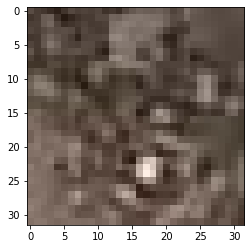

In [9]:
pa = glob('train/*.jpg')[0]
pa
g = tf.io.read_file(pa)
im = tf.io.decode_image(g)
print(im.shape)
plt.imshow(im)
plt.show()

In [10]:
input_shape = (32, 32, 3)
batch_size = 32

하지만 케글에서 실습을 하면서 강사님께서 알려주신 방법은 다음과 같다  
csv에서 ```id``` 열의 데이터를 활용해서 파일의 경로를 만들고 그에따른 label값을 ```has_cactus```열의 데이터로 만들었음

In [11]:
data_dir = 'train'

data_paths = []
for fname, label in zip(file_list, has_cactus) :
  data_paths.append((os.path.join(data_dir, fname), label))

In [12]:
data_paths[:10]

[('train/0004be2cfeaba1c0361d39e2b000257b.jpg', 1),
 ('train/000c8a36845c0208e833c79c1bffedd1.jpg', 1),
 ('train/000d1e9a533f62e55c289303b072733d.jpg', 1),
 ('train/0011485b40695e9138e92d0b3fb55128.jpg', 1),
 ('train/0014d7a11e90b62848904c1418fc8cf2.jpg', 1),
 ('train/0017c3c18ddd57a2ea6f9848c79d83d2.jpg', 1),
 ('train/002134abf28af54575c18741b89dd2a4.jpg', 0),
 ('train/0024320f43bdd490562246435af4f90b.jpg', 0),
 ('train/002930423b9840e67e5a54afd4768a1e.jpg', 1),
 ('train/00351838ebf6dff6e53056e00a1e307c.jpg', 1)]

### ***학습을 할때 validatio_data가 있으면 좋은 것일까?***
그전에 먼저 데이터에 대해서 알아본다  
<br>
#### 데이터의 종류
- Train Data
 - 분석 모델을 만들기 위한 학습용 데이터이다
- Validation Data
 - 여러 분석 모델 중 어떤 모델이 적합한지 선택하기 위한 검증용 데이터이다.
- Test Data
 - 최종적으로 선택된 분석 모델이 얼마나 잘 작동하는지 확인하기 위한 결과용 데이터이다.<br>

#### https://3months.tistory.com/118




```python
def read_data(path) :
  gfile = tf.io.read_file(path)
  image = tf.io.decode_image(gfile)

  class_name = tf.strings.split(path, '/')[-1]
  class_name = tf.strings.split(class_name, '_')[-1]
  class_name = tf.strings.split(class_name, '.')[0]

  onehot = tf.cast(labels == class_name, tf.uint8)

  return image, onehot
```

기존의 read_data는 위의 함수의 형태로 되어 있었다. (mnist, cifar10)  
mnist와 cifar와 같은 경우는 10개의 클래스로 분류하는 것
하지만 이 데이터는
- 입력된 사진으로 부터
  - 선인장이 있는지
  - 없는지
2가지로 분류하는 것  

- 이진분류? 
 - 이진 분류에서 많이 사용하는 활성화함수 : ```sigmoid```
 - 다중 분류에서 많이 사용되는 활성화함수 : ```softmax```
 - 추가적으로 이진분류의 loss는 ```binary_crossentroy``` 활용

In [13]:
def tmp_func (path_name) :
  return path_name

In [14]:
a = tf.data.Dataset.from_tensor_slices(np.array(data_paths[:2]))
a = a.map(tmp_func)
p = next(iter(a))
p[0], p[1]

(<tf.Tensor: shape=(), dtype=string, numpy=b'train/0004be2cfeaba1c0361d39e2b000257b.jpg'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'1'>)

In [15]:
def read_data(path_name) :
  img_path = path_name[0]
  label = tf.strings.to_number(path_name[1], out_type=tf.int64)

  gfile = tf.io.read_file(img_path)
  image = tf.io.decode_image(gfile)
  
  return image, label

이전에 만든 data_path에는 경로와 그에 따른 label값들이 들어가게 된다  
이를 각각 경로를 통해서 image를 읽어들이는 것과 label값을 return하도록 만든다  
<br>
**근데 .... label값을 그대로 return 해줘도 되는가?**  
<br>
이게 제일 의문점이다.  
image 자체는 ```tf.io.read_file```, ```tf.io.decode_image``` 기존에 사용했던 것들을 활용하면 되는 것  
이전에 mnist나 cifar10 같은 경우는 각 입력값들로부터 onehot encoding을 통해서 결과를 return해주었지만 여기선 이진 분류이기 때문에 **선인장이 있는가? 없는가?**를 판단 하는 것이고 ......

[shuffle에서 buffer_size](https://helloyjam.github.io/tensorflow/buffer-size-in-shuffle/)

이미지를 읽고 프로세싱하고 배치작업등의 무거운 작업을 하기 전에 tf.data.Dataset.shuffle()을 호출해야 한다  
+. ```tf.data.Dataset.from_tensor_slices((파일목록, 라벨값))```
 - 파일목록과 라벨값으로 데이터셋을 만드는 것.... 기억해두자

In [16]:
train_ratio = 0.8

train_paths = data_paths[:int(train_ratio*len(data_paths))]
test_paths = data_paths[int(train_ratio*len(data_paths)):]

In [17]:
train_ds = tf.data.Dataset.from_tensor_slices(np.array(train_paths))
train_ds = train_ds.map(read_data)
# print(next(iter(train_ds)))
# 이때 확인하면 image에 대한 tensor값과 그 이미지에 대한 라벨을 알 수 있음
train_ds = train_ds.shuffle(len(train_paths))
# shuffle에 대한 buffer_size에 관해서도(위에 참고)
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.repeat()

In [18]:
valid_ds = tf.data.Dataset.from_tensor_slices(np.array(test_paths))
valid_ds = valid_ds.map(read_data)
valid_ds = valid_ds.batch(batch_size)
valid_ds = valid_ds.repeat()

In [19]:
inputs = layers.Input(input_shape)

# Feature extraction
net = layers.Conv2D(32, 3, 1, 'SAME')(inputs)
net = layers.Activation('relu')(net)
net = layers.Conv2D(32, 3, 1, 'SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D((2, 2))(net)
net = layers.Dropout(0.5)(net)

net = layers.Conv2D(64, 3, 1, 'SAME')(net)
net = layers.Activation('relu')(net)
net = layers.Conv2D(64, 3, 1, 'SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D((2, 2))(net)
net = layers.Dropout(0.5)(net)

# classification
net = layers.Flatten()(net)
net = layers.Dense(512)(net)
net = layers.Activation('relu')(net)
net = layers.Dropout(0.5)(net)
net = layers.Dense(1)(net)
net = layers.Activation('sigmoid')(net)

model = tf.keras.Model(inputs=inputs, outputs=net, name='cactus_cnn')

In [20]:
model.summary()

Model: "cactus_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0

In [21]:
model.compile(loss = tf.keras.losses.binary_crossentropy,
              optimizer = tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [22]:
steps_per_epoch = len(train_paths) // batch_size
validation_steps = len(test_paths) // batch_size

In [23]:
hist = model.fit(train_ds,
                 validation_data=valid_ds,
                 validation_steps=validation_steps,
                 steps_per_epoch=steps_per_epoch,
                 epochs = 30)

Epoch 1/30
437/437 [==============================] - 6s 14ms/step - loss: 0.6817 - accuracy: 0.8886 - val_loss: 0.1477 - val_accuracy: 0.9452
Epoch 2/30
437/437 [==============================] - 10s 24ms/step - loss: 0.1450 - accuracy: 0.9437 - val_loss: 0.0931 - val_accuracy: 0.9693
Epoch 3/30
437/437 [==============================] - 11s 25ms/step - loss: 0.1286 - accuracy: 0.9490 - val_loss: 0.0952 - val_accuracy: 0.9713
Epoch 4/30
437/437 [==============================] - 10s 23ms/step - loss: 0.1152 - accuracy: 0.9560 - val_loss: 0.1090 - val_accuracy: 0.9584
Epoch 5/30
437/437 [==============================] - 11s 25ms/step - loss: 0.0975 - accuracy: 0.9627 - val_loss: 0.0877 - val_accuracy: 0.9676
Epoch 6/30
437/437 [==============================] - 11s 26ms/step - loss: 0.0876 - accuracy: 0.9663 - val_loss: 0.0636 - val_accuracy: 0.9791
Epoch 7/30
437/437 [==============================] - 11s 26ms/step - loss: 0.0846 - accuracy: 0.9671 - val_loss: 0.0603 - val_accuracy: 

KeyboardInterrupt: ignored

# 평가

In [24]:
test_df.head()

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.5
1,0017242f54ececa4512b4d7937d1e21e.jpg,0.5
2,001ee6d8564003107853118ab87df407.jpg,0.5
3,002e175c3c1e060769475f52182583d0.jpg,0.5
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.5


In [25]:
test_fnames[:5]

0    000940378805c44108d287872b2f04ce.jpg
1    0017242f54ececa4512b4d7937d1e21e.jpg
2    001ee6d8564003107853118ab87df407.jpg
3    002e175c3c1e060769475f52182583d0.jpg
4    0036e44a7e8f7218e9bc7bf8137e4943.jpg
Name: id, dtype: object

In [26]:
test_labels[:5]

0    0.5
1    0.5
2    0.5
3    0.5
4    0.5
Name: has_cactus, dtype: float64

In [27]:
test_dir = 'test'

eval_paths = []
for fname in test_fnames :
  eval_paths.append(os.path.join(test_dir, fname))

print(eval_paths[:5])

['test/000940378805c44108d287872b2f04ce.jpg', 'test/0017242f54ececa4512b4d7937d1e21e.jpg', 'test/001ee6d8564003107853118ab87df407.jpg', 'test/002e175c3c1e060769475f52182583d0.jpg', 'test/0036e44a7e8f7218e9bc7bf8137e4943.jpg']


In [28]:
def image_read(path) :
  g = tf.io.read_file(path)
  im = tf.io.decode_image(g)

  return im

In [29]:
from tqdm import tqdm_notebook

In [30]:
# test_images = [image_read(path) for path in eval_paths]

test_images = []
for path in tqdm_notebook(eval_paths) :
  test_images.append(image_read(path))

# np.array(test_image).shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [31]:
test_ds = tf.data.Dataset.from_tensor_slices(eval_paths)
test_ds = test_ds.map(image_read)
test_ds = test_ds.batch(batch_size)

In [32]:
pred = model.predict(test_ds)

In [33]:
pred.shape

(4000, 1)

In [34]:
pred = pred.reshape((4000))

In [36]:
# submit_df = pd.read_csv('../input/aerial-cactus-identification/sample_submission.csv')
submit_df = pd.read_csv('/content/sample_submission.csv')
test_fnames = submit_df['id']
test_labels = pred  # 결과가 onehot이 아닌 binary로 담아줘야함

submit_file = pd.DataFrame({'id':test_fnames, 'has_cactus':test_labels}, columns = ['id', 'has_cactus'])
submit_file
submit_file.to_csv('submission.csv', index=False)